오늘은 캐글의 폐렴환자 데이터를 이용하여, 폐렴 여부를 판단하는 프로젝트를 진행해 보았습니다.

데이터 출처 : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

폐렴의 정의는 다음과 같습니다.

> 폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.

출처 : https://ko.wikipedia.org/wiki/폐렴

폐렴의 구별법은 예상외로 가능합니다. 폐부위에 다양한 양상의 음영이 관찰됩니다. 아래 사진을 보면 이해가 가실 것 입니다.
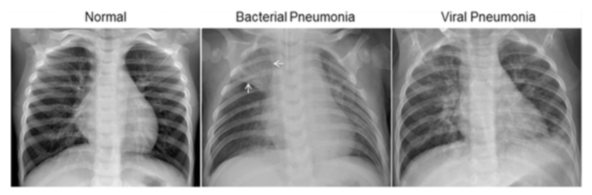

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 학습시킬 데이터 불러오기

In [2]:
# 앞으로 필요한 변수들을 생성합니다.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)


/aiffel/aiffel


데이터 구조는 다음과 같습니다.

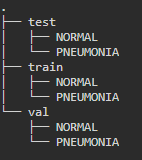

In [3]:
# 파일의 개수를 체크해보았습니다.

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# train, test, val 데이터 비율 나누기

train : test : val = 89 : 10.7 : 0.3 이므로 train에서 val에 쓰일 데이터를 더 가져와 주었습니다.

train과 val 데이터를 모은 다음, 80 : 20으로 분할하였습니다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


# 정상 환자 사진과 폐렴 환자의 사진 라벨 달기
train 데이터와 validation 데이터의 총 개수는 4185, 1047개이지만, 여기에 정상환자 사진과, 폐렴환자 사진이 어느정도의 비율로 들어가있는지는 알 지 못합니다. 그렇기 때문에 정상과 폐렴환자의 사진 비율을 세어 주었습니다.

### train과 validation set

In [5]:
# 정상 환자 사진과 폐렴환자 사진의 수를 세어보았습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
#이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해보았습니다.
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
print("\n\n")    
    
for image, label in val_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False



Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


### test

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(len(test_ds))

for image, label in test_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

id(image)    

39
Image shape:  (16, 180, 180, 3)
Label:  [False  True  True False  True  True  True  True False  True False False
  True  True False False]
Image shape:  (16, 180, 180, 3)
Label:  [False  True  True  True  True  True False  True  True  True False  True
  True  True  True  True]
Image shape:  (16, 180, 180, 3)
Label:  [ True False  True  True False False False False  True  True  True False
  True False  True  True]


139980138749440

# tensorflow pipeline

tf.data 파이프라인을 사용하면 학습 데이터를 효율적으로 사용할 수 있습니다.
이 파이프라인을 이용하여 prepare_for_training() 함수를 정의해보았습니다.

shuffle() 메소드를 사용해 고정 크기 버퍼를 유지하고 그 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 됩니다. 이때 repeat()를 사용한 데이터셋의 경우에는 여러 번 데이터셋을 사용할 수 있게 해줍니다.
- ex ) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요합니다. repeat()를 사용하면 자동으로 데이터가 맞춰집니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 
- ex ) 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어옵니다. 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있습니다. 그렇기 때문에 리소스의 유휴 상태를 줄일 수 있습니다.

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# sho

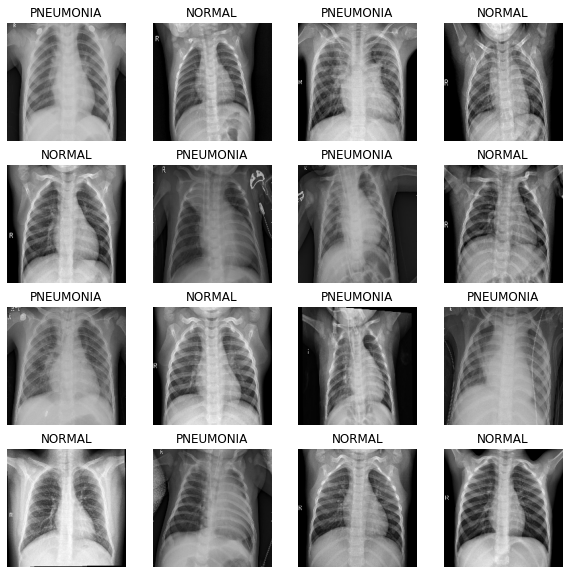

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 폐렴 진단해보기

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block은 아래와 같이 만듭니다.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 데이터 imbalance 처리

In [16]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다. 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [17]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 67s 210ms/step - loss: 0.3521 - accuracy: 0.8317 - precision: 0.9588 - recall: 0.8086 - val_loss: 0.6782 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2234 - accuracy: 0.9157 - precision: 0.9752 - recall: 0.9099 - val_loss: 1.2596 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2047 - accuracy: 0.9239 - precision: 0.9751 - recall: 0.9212 - val_loss: 0.1090 - val_accuracy: 0.9558 - val_precision: 0.9531 - val_recall: 0.9882
Epoch 4/25
261/261 [==============================] - 56s 214ms/step - loss: 0.1656 - accuracy: 0.9397 - precision: 0.9808 - recall: 0.9372 - val_loss: 0.5872 - val_accuracy: 0.8548 - val_precision: 0.9968 - val_recall: 0.8055
Epoch 5/25
261/261 [==============================] - 58s 221ms/step - loss: 0.1625 - accura

In [ ]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# 성능 개선

계획 : 성능 개선을 위하여, 이미지를 flip해주고, 회전을 해주는 층을 추가해 주었습니다.

# 1. Rotate data
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.03),
])

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        layers.experimental.preprocessing.RandomRotation(0.03),

        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# strafied k fold

https://guru.tistory.com/35

In [ ]:
len(filenames)

In [ ]:
COUNT_NORMAL = len([filename for filename in filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

In [ ]:
train_and_val_list_ds = tf.data.Dataset.from_tensor_slices(filenames)


In [ ]:
TRAIN_VAL_IMG_COUNT = tf.data.experimental.cardinality(train_and_val_list_ds).numpy()
print(f"Training images count: {TRAIN_VAL_IMG_COUNT}")

In [ ]:
train_val_ds = train_and_val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_val_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
print(type(train_val_ds))
print(train_val_ds)
print(len(train_val_ds))

In [ ]:
for image, label in train_val_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
print("\n\n")   
    
for image, label in train_val_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())    

In [ ]:
# train_val_ds = prepare_for_training(train_val_ds)

In [ ]:
# all_images_true = np.empty(shape=(180,180,3))
# all_images_false = np.empty(shape=(180,180,3))
# all_targets_true = np.empty(shape=1)
# all_targets_false = np.empty(shape=1)

all_images_true = []
all_images_false = []
all_targets_true = []
all_targets_false = []

len(train_val_ds)

# for image, label in train_val_ds.take(len(train_val_ds)):
#     if label.numpy():
#         all_images_true.append(image.numpy())
#         all_targets_true.append(label.numpy())
#     else:
#         all_images_false.append(image.numpy())
#         all_targets_false.append(label.numpy())
    
# print(len(all_images_false), len(all_images_true))    

for image, label in train_val_ds.take(len(train_val_ds)):
    if label.numpy():
        all_images_true.append(image.numpy())
        all_targets_true.append(label.numpy())
    else:
        all_images_false.append(image.numpy())
        all_targets_false.append(label.numpy())

회고
- image rotate하는게 정ㅇ말 맣ㄴ은 방법
PIL image로 해주는게있엇고
tensorflow 1에서만 돌아가는 rotation 방법도잇엇고,
image상태에서 돌리는게
tensor상태에서돌리는거
모델 layer 층에 쌓을때 돌리는거.

사실 cnn input 전에 넣어야하느지 후에넣어야하는지도 잘모르겟음 ㅎㅋ